<a name="top"></a><img src="source/SpinalHDL.png" alt="SpinalHDL based on Scala" style="width:320px;" />

  Before running Spinal HDL code, be sure to load SpinalHDL Libraries  
**Note** : This may be a little slow when the first time load, please wait a moment to download Lib from remote.)

In [ ]:
val path = System.getProperty("user.dir") + "/source/load-spinal.sc"
interp.load.module(ammonite.ops.Path(java.nio.file.FileSystems.getDefault().getPath(path)))

### Simple Example
##### default Clock and Reset

In [ ]:
class Top extends Component{
    val a = in Bits(8 bits)
    val b = RegNext(a) init 0
}
showRtl(new Top)

##### specific your owen Clock and Reset

In [ ]:
class Top extends Component{
    val myclk,myrst = in Bool()
    val a = in Bits(8 bits)
    val b = out Bits()
    new ClockingArea(ClockDomain(myclk,myrst)){
      val reg0 = RegNext(a) init 0
      b := reg0
    }
    
}
showRtl(new Top)

##### set Asynchronous Reset with Falling edge

In [ ]:
class Top extends Component{
    val myclk,myrst = in Bool()
    val a = in Bits(8 bits)
    val b = out Bits()
    new ClockingArea(ClockDomain(myclk,myrst, config = ClockDomainConfig(
      clockEdge        = RISING,
      resetKind        = ASYNC,
      resetActiveLevel = LOW
    ))){
      val reg0 = RegNext(a) init 0
      b := reg0
    }
}
showRtl(new Top)

##### Override the default clock of the sub module

In [ ]:
class SUB extends Component{
    val a = in Bits(8 bits)
    val b = out(RegNext(a) init 0)
}
class Top extends Component{
   val myclk,myrst = in Bool()
   val cd = ClockDomain(myclk,myrst, 
      config = ClockDomainConfig(
      clockEdge        = RISING,
      resetKind        = ASYNC,
      resetActiveLevel = LOW))
    val u_sub0 = cd(new SUB)
}
showRtl(new Top)

## Clock domains
In SpinalHDL, clock and reset signals can be combined to create a clock domain. Clock domains can be applied to some areas of the design and then all synchronous elements instantiated into those areas will then implicitly use this clock domain.

Clock domain application works like a stack, which means that if you are in a given clock domain you can still apply another clock domain locally.

The syntax to define a clock domain is as follows (using EBNF syntax):
```scala
ClockDomain(
  clock: Bool
  [,reset: Bool]
  [,softReset: Bool]
  [,clockEnable: Bool]
  [,frequency: IClockDomainFrequency]
  [,config: ClockDomainConfig]
)
```
defualt ClockDomain 
```scala 
case class ClockDomainConfig(clockEdge: EdgeKind = RISING,
                             resetKind: ResetKind = ASYNC,
                             resetActiveLevel: Polarity = HIGH,
                             softResetActiveLevel: Polarity = HIGH,
                             clockEnableActiveLevel: Polarity = HIGH)
```

### Internal Clock 
An alternative syntax to create a clock domain is the following:
```
ClockDomain.internal(
  name: String,
  [config: ClockDomainConfig,]
  [withReset: Boolean,]
  [withSoftReset: Boolean,]
  [withClockEnable: Boolean,]
  [frequency: IClockDomainFrequency]
)
```
Its advantage is to create clock and reset signals with a specified name instead of an inherited one. Then you have to assign those ClockDomain’s signals as shown in the example below:

In [ ]:
class Pll extends Component{
  val io = new Bundle {
    val clkIn = in Bool()
    val clkOut  = out Bool()
    val reset  = out Bool()
  }
  io.clkOut := io.clkIn
  io.reset  := False
}
class InternalClockWithPllExample extends Component {
  val io = new Bundle {
    val clk100M = in Bool()
    val aReset  = in Bool()
    val result  = out UInt (4 bits)
  }
  // myClockDomain.clock will be named myClockName_clk
  // myClockDomain.reset will be named myClockName_reset
  val myClockDomain = ClockDomain.internal("myClockName")

  // Instanciate a PLL (probably a BlackBox)
  val pll = new Pll()
  pll.io.clkIn := io.clk100M

  // Assign myClockDomain signals with something
  myClockDomain.clock := pll.io.clkOut
  myClockDomain.reset := io.aReset || !pll.io.reset

  // Do whatever you want with myClockDomain
  val myArea = new ClockingArea(myClockDomain){
    val myReg = Reg(UInt(4 bits)) init(7)
    myReg := myReg + 1

    io.result := myReg
  }
}
showRtl(new InternalClockWithPllExample)

### External clock

You can define a clock domain which is driven by the outside anywhere in your source. It will then automatically add clock and reset wire from the top level inputs to all synchronous elements. 
```
ClockDomain.external(
  name: String,
  [config: ClockDomainConfig,]
  [withReset: Boolean,]
  [withSoftReset: Boolean,]
  [withClockEnable: Boolean,]
  [frequency: IClockDomainFrequency]
)
```
The arguments to the `ClockDomain.external` function are exactly the same as in the `ClockDomain.internal` function. Below an example of a design using `ClockDomain.external`.

In [ ]:
class ExternalClockExample extends Component {
  val io = new Bundle {
    val result = out UInt (4 bits)
  }

  // On top level you have two signals  :
  //     myClockName_clk and myClockName_reset
  val myClockDomain = ClockDomain.external("myClockName")

  val myArea = new ClockingArea(myClockDomain){
    val myReg = Reg(UInt(4 bits)) init(7)
    myReg := myReg + 1

    io.result := myReg
  }
}
showRtl(new ExternalClockExample)

### Context
You can retrieve in which clock domain you are by calling `ClockDomain.current` anywhere.
The returned ClockDomain instance has the following functions that can be called:

name | Description | Return
-|-|-
frequency.getValue | Return the frequency of the clock domain | Double
hasResetSignal  | Return if the clock domain has a reset signal | Boolean
hasSoftResetSignal | Return if the clock domain has a reset signal |Boolean
hasClockEnableSignal | Return if the clock domain has a clock enable signal|Boolean
readClockWire | Return a signal derived by the clock signal | Bool
readResetWire | Return a signal derived by the reset signal | Bool
readSoftResetWire | Return a signal derived by the reset signal | Bool
readClockEnableWire | Return a signal derived by the clock enable signal | Bool
isResetActive | Return True when the reset is active | Bool
isSoftResetActive | Return True when the softReset is active | Bool
isClockEnableActive | Return True when the clock enable is active | Bool

In [ ]:
class T0 extends Component {
  println(ClockDomain.current)
  val coreClock,coreReset = in Bool()
  val coreClockDomain = ClockDomain(coreClock, coreReset, frequency=FixedFrequency(99 MHz) )
  println(coreClockDomain.hasResetSignal)
  println(coreClockDomain.frequency.getValue)
  println(coreClockDomain.hasSoftResetSignal)
  println(coreClockDomain.isResetActive)  
}
showRtl(new T0)

### Clock domain crossing
SpinalHDL checks at compile time that there is no unwanted/unspecified cross clock domain signal reads. If you want to read a signal that is emitted by another ClockDomain area, you should add the crossClockDomain tag to the destination signal as depicted in the following example:

In [ ]:
//             _____                        _____             _____
//            |     |  (crossClockDomain)  |     |           |     |
//  dataIn -->|     |--------------------->|     |---------->|     |--> dataOut
//            | FF  |                      | FF  |           | FF  |
//  clkA   -->|     |              clkB -->|     |   clkB -->|     |
//  rstA   -->|_____|              rstB -->|_____|   rstB -->|_____|



// Implementation where clock and reset pins are given by components IO
class CrossingExample extends Component {
  val io = new Bundle {
    val clkA = in Bool()
    val rstA = in Bool()

    val clkB = in Bool()
    val rstB = in Bool()

    val dataIn  = in Bool()
    val dataOut = out Bool()
  }

  // sample dataIn with clkA
  val area_clkA = new ClockingArea(ClockDomain(io.clkA,io.rstA)){
    val reg = RegNext(io.dataIn) init(False)
  }

  // 2 register stages to avoid metastability issues
  val area_clkB = new ClockingArea(ClockDomain(io.clkB,io.rstB)){
    val buf0   = RegNext(area_clkA.reg) init(False) addTag(crossClockDomain)
    val buf1   = RegNext(buf0)          init(False)
  }

  io.dataOut := area_clkB.buf1
}
showRtl(new CrossingExample)

In [ ]:
//Alternative implementation where clock domains are given as parameters
class CrossingExample(clkA : ClockDomain,clkB : ClockDomain) extends Component {
  val io = new Bundle {
    val dataIn  = in Bool()
    val dataOut = out Bool()
  }

  // sample dataIn with clkA
  val area_clkA = new ClockingArea(clkA){
    val reg = RegNext(io.dataIn) init(False)
  }

  // 2 register stages to avoid metastability issues
  val area_clkB = new ClockingArea(clkB){
    val buf0   = RegNext(area_clkA.reg) init(False) addTag(crossClockDomain)
    val buf1   = RegNext(buf0)          init(False)
  }

  io.dataOut := area_clkB.buf1
}

### Set the default clock domain for different modules

In [ ]:
class MYSub0(cd: ClockDomain) extends Component {
  val io = new Bundle{
    val ai = in UInt(8 bits)
    val ao = out UInt(8 bits)
  }
  io.ao := RegNext(io.ai) init(0)
}

class MYSub1(cd: ClockDomain) extends Component {
  val io = new Bundle{
    val ai = in UInt(8 bits)
    val ao = out UInt(8 bits)
    val a2 = out UInt(8 bits)
  } 
  io.ao := RegNext(io.ai) init(0)
  val cd2 = ClockDomain.external("adc")
  //alow another clockDomain not confict to default clockdomain 
  val area = new ClockingArea(cd2){
    val tmp = RegNext(io.ai) init(0)
    val tmp2 = tmp + (RegNext(io.ai) init(0))
  } 
  io.a2 := area.tmp2
}     

class Top00 extends Component {
  val io = new Bundle{
    val a = in UInt(8 bits)
    val b0 = out UInt(8 bits)
    val b1 = out UInt(8 bits)
    val b2 = out UInt(8 bits)
  }
  val cd0 = ClockDomain.external("cp")
  val cd1 = ClockDomain.external("ap")

  val u_sub0 = cd0(new MYSub0(cd0)) // set u_sub0's default clockDomain with cd0
  val u_sub1 = cd1(new MYSub1(cd1)) // it allow anoter clockDomain in ther module

  u_sub0.io.ai := io.a
  u_sub1.io.ai := io.a

  io.b0 := u_sub0.io.ao
  io.b1 := u_sub1.io.ao
  io.b2 := u_sub1.io.a2

  val tmp = RegNext(io.a) init(0)
}

showRtl(new Top00)

## ResetArea
A ResetArea is used to create a new clock domain area where a special reset signal is combined with the current clock domain reset.

In [ ]:
class TopLevel extends Component {

  val specialReset = in Bool()

  // The reset of this area is done with the specialReset signal
  val areaRst_1 = new ResetArea(reset=specialReset, cumulative=false){
    val counter = out(CounterFreeRun(16).value)
  }

  // The reset of this area is a combination between the current reset and the specialReset
  val areaRst_2 = new ResetArea(reset=specialReset, cumulative=true){
    val counter = out(CounterFreeRun(16).value)
  }
}
showRtl(new TopLevel)

## ClockEnableArea
A ClockEnableArea is used to add an additional clock enable in the current clock domain.ResetArea
A ResetArea is used to create a new clock domain area where a special reset signal is combined with the current clock domain reset.

In [ ]:
class TopLevel extends Component {

  val clockEnable = in Bool()

  // Add a clock enable for this area
  val area_1 = new ClockEnableArea(clockEnable){
    val counter = out(CounterFreeRun(16).value)
  }
}
showRtl(new TopLevel)

## ClockDomain SetSyncWith

Sometimes you may need to divide the clock or gate it,

However, these operations may not affect their synchronous clock relationship, but the new two clockdomains will be considered as two different clock domains by SpinalHDL as default

Therefore, they need to be manually set to be synchronized. Perhaps in future versions, the processing of these synchronizations can be completed automatically.

But it's also very easy to set the two clocks-family to be synchronous. Only `setSyncWith` is needed

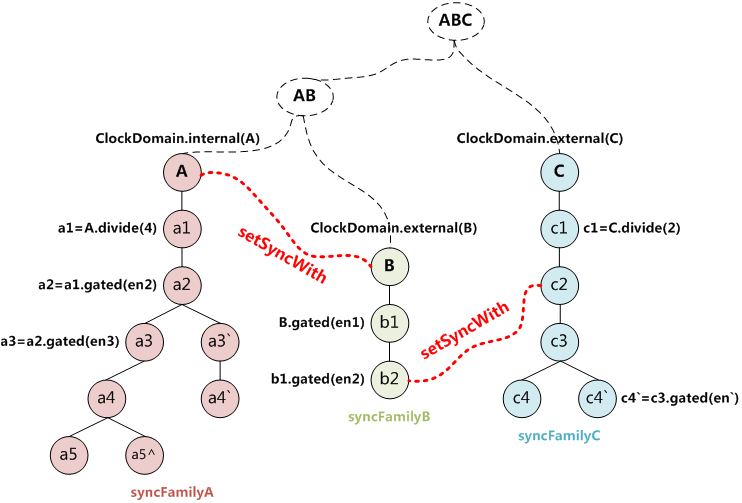

In [ ]:
class gate_cell extends Component{
    val io = new {
      val TSE,CLK,E = in Bool()
      val ECK = out Bool()        
    }
    noIoPrefix()
    
    val clk_n = !io.CLK
    val lock_en = Bool.noCombLoopCheck
    when (clk_n) {
        lock_en := io.E
    }.otherwise {
        lock_en := lock_en
    }
    io.ECK := lock_en && io.CLK
}

implicit class ClockGateExtend(cd: ClockDomain){
    def gateBy(en: Bool, tse: Bool): ClockDomain = {
      val cg = new gate_cell
      cg.io.CLK := cd.readClockWire
      cg.io.TSE := tse
      cg.io.E   := en
      val cde = ClockDomain(clock = cg.io.ECK,
        reset = cd.readResetWire
      )
      cde.setSynchronousWith(cd)
      cde
    }
  }

class A extends Component{
    
val clk,rstn,E,TSE = in Bool()
val clk_cg = out Bool()
val cd =ClockDomain(clk,rstn)
clk_cg := clockDomain.gateBy(E, TSE).readClockWire
    
}
showRtl(new A)

clockGate Usage

In [ ]:
class MySub extends Component {
    val io = new Bundle{
        val a = in UInt(8 bits)
        val b = out UInt(8 bits)
    }
    io.b := RegNext(io.a) init(0)
}

class Top extends Component {
    val io = new Bundle{
        val a0,a1 = in UInt(8 bits)
        val cg_en0,cg_en1 = in Bool()
        val b  = out UInt(8 bits)
        val test_mode = in Bool()
    }
 
    val cgd0 = clockDomain.gateBy(io.cg_en0, io.test_mode)
    val cgd1 = clockDomain.gateBy(io.cg_en1, io.test_mode)
     
    val u_sub0 = cgd0(new MySub)
    val u_sub1 = cgd1(new MySub)
    
    u_sub0.io.a := io.a0
    u_sub1.io.a := io.a1 
    
    io.b := RegNext(u_sub0.io.b + u_sub1.io.b) init 0
}

showRtl(new Top)

gate Cell with BlackBox 

In [ ]:
class gate_cell extends BlackBox {
  val io = new Bundle{
    val CLK = in Bool()
    val TSE = in Bool()
    val E   = in Bool()
    val ECK = out Bool()
  }

  noIoPrefix()

  val clk_n   = !io.CLK
  val lock_en = Bool().noCombLoopCheck

  when(clk_n){
    lock_en := io.E
  }.otherwise{
    lock_en := lock_en
  }

  io.ECK := (lock_en && io.CLK)
  if(CommonCellBlackBox.clear){this.clearBlackBox()}
}

implicit class ClockGateExtend(cd: ClockDomain){
    def gateBy(en: Bool, tse: Bool): ClockDomain = {
      val cg = new gate_cell
      cg.io.CLK := cd.readClockWire
      cg.io.TSE := tse
      cg.io.E   := en
      val cde = ClockDomain(clock = cg.io.ECK,
        reset = cd.readResetWire
      )
      cde.setSynchronousWith(cd)
      cde
    }
  }

protected object CommonCellBlackBox {
    private var _clear: Boolean = false
    def clear: Boolean = _clear
    def clear_=(x: Boolean) { _clear = x}
  }

  object clearCCBB{
    def apply() = CommonCellBlackBox.clear = true
  }


In [ ]:
class Top extends Component {
    val io = new Bundle{
      val clken = in Bool()
      val test_mode = in Bool()
      val clkout = out Bool()
    }
 
    val cgd0 = clockDomain.gateBy(io.clken, io.test_mode)
    
    io.clkout := cgd0.readClockWire
}
// clearCCBB()  //open and try
showRtl(new Top)